<a href="https://colab.research.google.com/github/AlanGitLP/UM-w-finansach/blob/main/UM_w_finansach_zad_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Shape (full): (284807, 31)
Missing values per column (non-zero only):
Series([], dtype: int64)
Udział klasy pozytywnej (oszustwa): 0.1727% (liczba pozytywnych: 492)
After downsample: (35000, 31) | frauds: 492 | fraud share: 1.4057%


/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



=== CV (StratifiedKFold, sort wg PR-AUC) ===
                 model  roc_auc_mean  roc_auc_std  avg_precision_mean  avg_precision_std  recall_mean  recall_std  f1_mean   f1_std  precision_mean  precision_std
RandomForest_resampled      0.979193     0.013087            0.892941           0.022810     0.870529    0.012711 0.854507 0.017138        0.839794       0.031864
      LogReg_resampled      0.975782     0.010986            0.880153           0.030527     0.898345    0.031645 0.629363 0.040311        0.484857       0.039739
   LinearSVC_resampled      0.975751     0.012046            0.863035           0.044585     0.890750    0.030096 0.652692 0.044432        0.515787       0.046623

>>> Najlepszy wg PR-AUC (CV): RandomForest_resampled
PCA n_components_: 26

Wybrany próg (F_beta, beta=1.0): 0.737500 | F_beta=0.9189 | P=0.9855 | R=0.8608

=== TEST (hold-out) — próg DOMYŚLNY ===
ROC AUC: 0.9804
PR AUC (Average Precision): 0.8785
Confusion matrix [[TN, FP], [FN, TP]]:
[[6898    4]
 

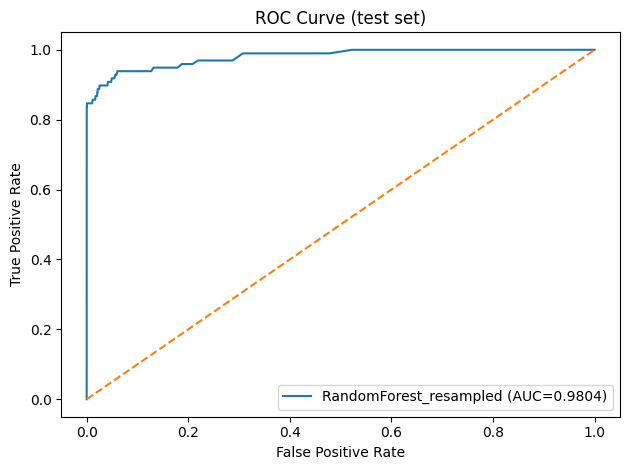

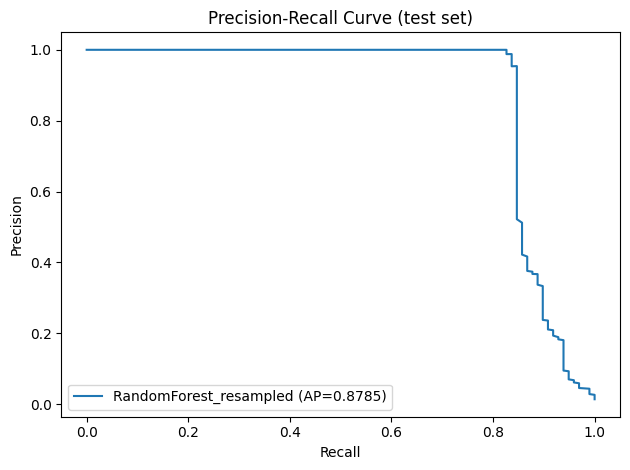


=== Uzasadnienie wyboru modelu ===
W detekcji oszustw (ekstremalnie niezbalansowanej) kluczowa jest krzywa Precision–Recall, dlatego kryterium wybororu w CV to Average Precision (PR-AUC). Przetwarzanie wykonano w pipeline bez wycieków: imputacja → standaryzacja → PCA → SMOTE → undersampling. Zastosowano częściowe bilansowanie (~1:2) zgodne z treścią zadania. Po wyborze najlepszego modelu próg decyzji dostrojono na walidacji (maks. F_beta), aby dopasować trade-off precision/recall do celu. Wyniki raportowane na nieużywanym wcześniej zbiorze testowym.


In [3]:
import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    average_precision_score, precision_recall_curve, roc_curve
)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

import matplotlib.pyplot as plt

CSV_PATH = Path("creditcard.csv")
RANDOM_STATE = 42
ENABLE_DOWNSAMPLE = True
DOWNSAMPLED_SIZE = 35_000
TEST_SIZE = 0.20
N_SPLITS_CV = 5
BETA = 1.0

df = pd.read_csv(CSV_PATH)
print(f"Shape (full): {df.shape}")
print("Missing values per column (non-zero only):")
missing = df.isna().sum()
print(missing[missing > 0])

assert "Class" in df.columns, "Brakuje kolumny 'Class' w danych!"
print(f"Udział klasy pozytywnej (oszustwa): {df['Class'].mean()*100:.4f}% (liczba pozytywnych: {int(df['Class'].sum())})")

def downsample_to_target(df_in: pd.DataFrame, target_col="Class", total_target=35_000, seed=RANDOM_STATE) -> pd.DataFrame:
    pos = df_in[df_in[target_col] == 1]
    neg = df_in[df_in[target_col] == 0]
    n_pos = len(pos)
    n_neg_target = max(min(total_target - n_pos, len(neg)), 0)
    neg_sample = neg.sample(n=n_neg_target, random_state=seed)
    out = pd.concat([pos, neg_sample]).sample(frac=1.0, random_state=seed).reset_index(drop=True)
    return out

if ENABLE_DOWNSAMPLE:
    df = downsample_to_target(df, target_col="Class", total_target=DOWNSAMPLED_SIZE, seed=RANDOM_STATE)
    print(f"After downsample: {df.shape} | frauds: {int(df['Class'].sum())} | fraud share: {df['Class'].mean()*100:.4f}%")

X = df.drop(columns=["Class"])
y = df["Class"]

X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

imputer = SimpleImputer(strategy="median")
scaler = StandardScaler(with_mean=True, with_std=True)
pca = PCA(n_components=0.95, random_state=RANDOM_STATE)


over = SMOTE(sampling_strategy=0.10, random_state=RANDOM_STATE)
under = RandomUnderSampler(sampling_strategy=0.50, random_state=RANDOM_STATE)

base_steps = [
    ("impute", imputer),
    ("scaler", scaler),
    ("pca", pca),
    ("smote", over),
    ("under", under),
]

models = {
    "LogReg_resampled": ImbPipeline(
        steps=base_steps + [
            ("clf", LogisticRegression(max_iter=5000, solver="lbfgs", random_state=RANDOM_STATE))
        ]
    ),
    "LinearSVC_resampled": ImbPipeline(
        steps=base_steps + [
            ("clf", LinearSVC(C=1.0, max_iter=10000, dual=True, random_state=RANDOM_STATE))
        ]
    ),
    "RandomForest_resampled": ImbPipeline(
        steps=base_steps + [
            ("clf", RandomForestClassifier(n_estimators=400, n_jobs=-1, random_state=RANDOM_STATE))
        ]
    ),
}

cv = StratifiedKFold(n_splits=N_SPLITS_CV, shuffle=True, random_state=RANDOM_STATE)

def decision_scores(est, X_):
    if hasattr(est, "decision_function"):
        s = est.decision_function(X_)
        if isinstance(s, np.ndarray) and s.ndim > 1:
            s = s[:, 1]
        return s
    if hasattr(est, "predict_proba"):
        return est.predict_proba(X_)[:, 1]
    return est.predict(X_).astype(float)

def crossval_metrics(pipe, X_tr, y_tr, cv_obj):
    from sklearn.metrics import recall_score, f1_score, precision_score
    rocs, aps, recs, f1s, precs = [], [], [], [], []
    for tr_idx, val_idx in cv_obj.split(X_tr, y_tr):
        X_tr_i, X_val = X_tr.iloc[tr_idx], X_tr.iloc[val_idx]
        y_tr_i, y_val = y_tr.iloc[tr_idx], y_tr.iloc[val_idx]
        pipe.fit(X_tr_i, y_tr_i)
        s = decision_scores(pipe, X_val)
        y_hat = pipe.predict(X_val)
        rocs.append(roc_auc_score(y_val, s))
        aps.append(average_precision_score(y_val, s))
        recs.append(recall_score(y_val, y_hat, zero_division=0))
        f1s.append(f1_score(y_val, y_hat, zero_division=0))
        precs.append(precision_score(y_val, y_hat, zero_division=0))
    def meanstd(a): return (float(np.mean(a)), float(np.std(a)))
    return {
        "roc_auc": meanstd(rocs),
        "avg_precision": meanstd(aps),
        "recall": meanstd(recs),
        "f1": meanstd(f1s),
        "precision": meanstd(precs),
    }

cv_rows = []
for name, pipe in models.items():
    m = crossval_metrics(pipe, X_train_full, y_train_full, cv)
    row = {"model": name}
    for k, (mu, sd) in m.items():
        row[f"{k}_mean"] = mu
        row[f"{k}_std"] = sd
    cv_rows.append(row)

cv_df = pd.DataFrame(cv_rows).sort_values(by="avg_precision_mean", ascending=False)
print("\n=== CV (StratifiedKFold, sort wg PR-AUC) ===")
print(cv_df.to_string(index=False))

best_name = cv_df.iloc[0]["model"]
print(f"\n>>> Najlepszy wg PR-AUC (CV): {best_name}")

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.20, random_state=RANDOM_STATE, stratify=y_train_full
)

best_pipe = models[best_name]
best_pipe.fit(X_train, y_train)

try:
    n_comp = best_pipe.named_steps["pca"].n_components_
    print(f"PCA n_components_: {n_comp}")
except Exception:
    pass

def best_threshold_by_fbeta(y_true, scores, beta=1.0):
    """Zwraca (best_thr, best_fbeta, precision_at_best, recall_at_best)."""
    prec, rec, thr = precision_recall_curve(y_true, scores)
    prec = prec[:-1]; rec = rec[:-1]
    thr = thr
    beta2 = beta**2
    fbeta = (1+beta2) * (prec*rec) / (beta2*prec + rec + 1e-12)
    idx = int(np.argmax(fbeta))
    return float(thr[idx]), float(fbeta[idx]), float(prec[idx]), float(rec[idx])

scores_val = decision_scores(best_pipe, X_val)
thr_best, fbeta_best, prec_best, rec_best = best_threshold_by_fbeta(y_val, scores_val, beta=BETA)
print(f"\nWybrany próg (F_beta, beta={BETA}): {thr_best:.6f} | F_beta={fbeta_best:.4f} | P={prec_best:.4f} | R={rec_best:.4f}")

best_pipe.fit(X_train_full, y_train_full)

s_test = decision_scores(best_pipe, X_test)
y_pred_default = best_pipe.predict(X_test)
y_pred_tuned = (s_test >= thr_best).astype(int)

def report_block(y_true, y_pred, scores):
    roc = roc_auc_score(y_true, scores)
    ap = average_precision_score(y_true, scores)
    cm = confusion_matrix(y_true, y_pred)
    rep = classification_report(y_true, y_pred, digits=4)
    return roc, ap, cm, rep

print("\n=== TEST (hold-out) — próg DOMYŚLNY ===")
roc, ap, cm, rep = report_block(y_test, y_pred_default, s_test)
print(f"ROC AUC: {roc:.4f}")
print(f"PR AUC (Average Precision): {ap:.4f}")
print("Confusion matrix [[TN, FP], [FN, TP]]:")
print(cm)
print("\nClassification report:")
print(rep)

print("\n=== TEST (hold-out) — próg DOSTROJONY (F_beta) ===")
roc2, ap2, cm2, rep2 = report_block(y_test, y_pred_tuned, s_test)
print(f"ROC AUC (identyczny, liczone na score): {roc2:.4f}")
print(f"PR AUC (identyczny, liczone na score):  {ap2:.4f}")
print("Confusion matrix [[TN, FP], [FN, TP]]:")
print(cm2)
print("\nClassification report:")
print(rep2)

fpr, tpr, _ = roc_curve(y_test, s_test)
plt.figure()
plt.plot(fpr, tpr, label=f"{best_name} (AUC={roc:.4f})")
plt.plot([0,1],[0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (test set)")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

prec, rec, _ = precision_recall_curve(y_test, s_test)
plt.figure()
plt.plot(rec, prec, label=f"{best_name} (AP={ap:.4f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (test set)")
plt.legend(loc="lower left")
plt.tight_layout()
plt.show()

print("\n Uzasadnienie wyboru modelu")
print(
    "W detekcji oszustw (ekstremalnie niezbalansowanej) kluczowa jest krzywa Precision–Recall, "
    "dlatego kryterium wybororu w CV to Average Precision (PR-AUC). "
    "Przetwarzanie wykonano w pipeline bez wycieków: imputacja → standaryzacja → PCA → SMOTE → undersampling. "
    "Po wyborze najlepszego modelu próg decyzji dostrojono na walidacji (maks. F_beta), "
    "aby dopasować trade-off precision/recall do celu. Wyniki raportowane na nieużywanym wcześniej zbiorze testowym."
)
